In [1]:
# =========================
# Imports
# =========================
using LinearAlgebra
using Statistics
using Printf
using Parameters         # @with_kw for keyword structs
using Distributions

In [2]:
# =========================
# Cell 2 — Structs 
# =========================

@with_kw struct UnskilledParams
    # Discounting / turnover
    r::Float64
    ν::Float64

    # Flow payoffs and sector shifter (scalar: you choose low-z or high-z manually)
    bU::Float64
    bT::Float64
    PU::Float64

    # Matching
    μU::Float64
    ηU::Float64

    # Vacancy cost
    kU::Float64

    # Damage shocks: p' ~ Beta(α,1)
    λU::Float64
    αU::Float64

    # Nash bargaining
    βU::Float64

    # Training completion
    ϕ::Float64

    # Training cost function c(x)
    c::Function

    # Exogenous worker type distribution x ~ Beta(a_x, b_x)
    a_x::Float64
    b_x::Float64
end

@with_kw struct UnskilledGrids
    # Worker type grid
    x::Vector{Float64}

    # Efficiency grid p in [0,1], must include 1.0
    p::Vector{Float64}

    # For robust integration: bin edges and bin masses on x
    x_edges::Vector{Float64}      # length Nx+1
end

@with_kw struct UnskilledSettings
    # Iteration controls (used later)
    maxit_inner::Int = 500
    maxit_outer::Int = 500
    tol_inner::Float64 = 1e-8
    tol_outer::Float64 = 1e-8
    verbose::Bool = true
end

@with_kw mutable struct UnskilledState
    # Outer objects (scalar tightness, vector pstar over x)
    θU::Float64                   # market tightness (chosen/updated later)
    pstar::Vector{Float64}        # p*(x), length Nx
    τ::BitVector                  # τ(x) ∈ {0,1}, length Nx

    # Distributions (stored as bin masses over x; sum is total mass in that state)
    u_mass::Vector{Float64}       # mass in untrained unemployment by x-bin, length Nx
    t_mass::Vector{Float64}       # mass in training by x-bin, length Nx

    # Values on x-grid
    Usearch::Vector{Float64}      # U_U^{search}(x)
    U::Vector{Float64}            # U_U(x)
    Tval::Vector{Float64}         # T(x)

    # Match values on (x,p)
    EU::Matrix{Float64}           # E_U(x,p), size (Nx,Np)
    JU::Matrix{Float64}           # J_U(x,p), size (Nx,Np)

    # Convenience: frontier surplus at p=1
    J_frontier::Vector{Float64}   # J_U(x,1), length Nx
end


@with_kw mutable struct UnskilledCache
    Nx::Int
    Np::Int
    jp1::Int                      # index of p==1.0

    # Exogenous worker distribution as bin masses (robust, sums to 1)
    ell_mass::Vector{Float64}     # length Nx

    # Scratch
    tmp_x::Vector{Float64}        # length Nx
    tmp_p::Vector{Float64}        # length Np
end

UnskilledCache

In [3]:
# =========================
# Cell 3 — Utilities
# =========================

# Matching: job-filling and job-finding
@inline qU(par::UnskilledParams, θ::Float64) = par.μU * θ^(-par.ηU)
@inline fU(par::UnskilledParams, θ::Float64) = θ * qU(par, θ)

# Damage redraw CDF: p' ~ Beta(α,1) => G(p) = p^α on [0,1]
@inline function G_beta1(p::Float64, α::Float64)
    p <= 0.0 && return 0.0
    p >= 1.0 && return 1.0
    return p^α
end

# Robust bin edges from nodes on [0,1]
function bin_edges_from_nodes(x::Vector{Float64})
    n = length(x)
    @assert n >= 2
    @assert isapprox(x[1], 0.0; atol=1e-12) && isapprox(x[end], 1.0; atol=1e-12) "x-grid should start at 0 and end at 1"
    @assert issorted(x)

    e = zeros(Float64, n+1)
    e[1] = 0.0
    e[end] = 1.0
    @inbounds for i in 2:n
        e[i] = 0.5 * (x[i-1] + x[i])
    end
    return e
end

# Bin masses for x ~ Beta(a,b): m[i] = P(x in (edge[i], edge[i+1]))
# This avoids evaluating pdf on grid nodes.
function beta_bin_masses(x_edges::Vector{Float64}, a::Float64, b::Float64)
    dist = Beta(a, b)
    n = length(x_edges) - 1
    m = zeros(Float64, n)
    @inbounds for i in 1:n
        m[i] = cdf(dist, x_edges[i+1]) - cdf(dist, x_edges[i])
    end
    s = sum(m)
    @assert s > 0
    m ./= s
    return m
end

# Find index of p==1.0 (frontier)
function frontier_index(p::Vector{Float64})
    j = findfirst(==(1.0), p)
    j === nothing && error("p-grid must contain 1.0 exactly (include 1.0 in range).")
    return j
end

frontier_index (generic function with 1 method)

In [4]:
# =========================
# Cell 4 — Initialize model
# =========================

"""
    initialize_unskilled(par, grid; set=UnskilledSettings(), θ0=1.0, pstar0=0.2, u_rate0=0.1)

Create (state, cache, set) for the unskilled block in a *single* manually-chosen regime
(i.e., you pass scalars bU,bT,PU,αU corresponding to "low z" or "high z").

Representation choice:
- We store cross-sectional objects over x as **bin masses** (robust): sum(u_mass) = total untrained unemployed mass.
- Values are stored on x-nodes as usual.
"""
function initialize_unskilled(par::UnskilledParams, grid::UnskilledGrids;
                             set::UnskilledSettings = UnskilledSettings(),
                             θ0::Real = 1.0,
                             pstar0::Real = 0.2,
                             u_rate0::Real = 0.1)

    Nx = length(grid.x)
    Np = length(grid.p)

    @assert length(grid.x_edges) == Nx + 1
    @assert isapprox(maximum(grid.p), 1.0; atol=1e-12) "p-grid must include 1.0"

    jp1 = frontier_index(grid.p)

    # Exogenous worker distribution: bin masses over x
    ell_mass = beta_bin_masses(grid.x_edges, par.a_x, par.b_x)  # sums to 1

    # Initial distributions: u integrates to u_rate0; t starts at 0
    u_mass = u_rate0 .* ell_mass
    t_mass = zeros(Nx)

    # Initial guesses
    θ_init = Float64(θ0)
    pstar_init = fill(Float64(pstar0), Nx)
    τ_init = falses(Nx)

    # Values
    Usearch = zeros(Nx)
    U       = zeros(Nx)
    Tval    = zeros(Nx)

    # Match values
    EU = zeros(Nx, Np)
    JU = zeros(Nx, Np)
    J_frontier = zeros(Nx)

    state = UnskilledState(;
        θU = θ_init,
        pstar = pstar_init,
        τ = τ_init,
        u_mass = u_mass,
        t_mass = t_mass,
        Usearch = Usearch,
        U = U,
        Tval = Tval,
        EU = EU,
        JU = JU,
        J_frontier = J_frontier
    )

    cache = UnskilledCache(;
        Nx = Nx,
        Np = Np,
        jp1 = jp1,
        ell_mass = ell_mass,
        tmp_x = zeros(Nx),
        tmp_p = zeros(Np)
    )

    return state, cache, set
end

initialize_unskilled

In [5]:
# =========================
# Cell 5 — Test initialization
# =========================

# --- Grids
Nx = 50
Np = 41
xgrid = collect(range(0.0, 1.0; length=Nx))
pgrid = collect(range(0.0, 1.0; length=Np))  # includes 1.0 exactly

x_edges = bin_edges_from_nodes(xgrid)

grid = UnskilledGrids(; x=xgrid, p=pgrid, x_edges=x_edges)

# --- Params (choose one regime manually: plug your "low-z" or "high-z" numbers)
par = UnskilledParams(;
    r=0.05, ν=0.02,
    bU=0.30,
    bT=0.25,
    PU=1.0,
    μU=0.7, ηU=0.5,
    kU=0.5,
    λU=0.4, αU=2.0,
    βU=0.5,
    ϕ=0.25,
    c = x -> 0.01 * exp(-x),
    a_x=2.0, b_x=5.0
)

state, cache, set = initialize_unskilled(par, grid; θ0=1.0, pstar0=0.2, u_rate0=0.1)

println("Initialized OK.")
println("Nx=$(cache.Nx), Np=$(cache.Np), jp1=$(cache.jp1)")
println("θU: ", state.θU)
println("pstar size: ", length(state.pstar), "  min/max=", (minimum(state.pstar), maximum(state.pstar)))
println("ell_mass sum: ", sum(cache.ell_mass))
println("u_mass sum:   ", sum(state.u_mass), "   (target u_rate0=0.1)")
println("t_mass sum:   ", sum(state.t_mass))
println("EU size: ", size(state.EU), "  JU size: ", size(state.JU))

Initialized OK.
Nx=50, Np=41, jp1=41
θU: 1.0
pstar size: 50  min/max=(0.2, 0.2)
ell_mass sum: 1.0
u_mass sum:   0.10000000000000002   (target u_rate0=0.1)
t_mass sum:   0.0
EU size: (50, 41)  JU size: (50, 41)


In [6]:
# =========================
# Cell 6 — Inner-loop code (value-function iteration given θU and pstar)
# =========================

"""
Design choices (consistent with your notes):
- Inner loop takes θU and pstar as given (outer objects).
- Takes US(x) as a *function* provided externally (later from skilled block).
- Updates in the sequence:
    1) T(x)
    2) U(x) and τ(x)
    3) (E,J) via surplus S (closed form) + expectation terms under Beta(α,1)
    4) Usearch(x) via your pointwise update using J(x,1)

Key computational trick:
- Integrals w.r.t. dG(p) where G(p)=p^α are done using **bin masses under G**
  (no pdf evaluations). Precompute these masses once from p-grid edges.

We do NOT solve a full (x,p) fixed point for E,J here; instead we use
the analytically implied fixed point in terms of total surplus S and the
continuation value M(x) = E_{p'~G}[S(x,p')^+ | p'≥p*(x)].

This is the standard shortcut implied by Nash bargaining + linear flow output.
"""

# ---------- utilities for Beta(α,1) measure on p-grid ----------
function p_edges_from_nodes(p::Vector{Float64})
    n = length(p)
    @assert n >= 2
    @assert isapprox(p[1], 0.0; atol=1e-12) && isapprox(p[end], 1.0; atol=1e-12)
    @assert issorted(p)
    e = zeros(Float64, n+1)
    e[1] = 0.0
    e[end] = 1.0
    @inbounds for j in 2:n
        e[j] = 0.5 * (p[j-1] + p[j])
    end
    return e
end

# Bin masses under G(p)=p^α: m[j] = P(p' in (edge[j], edge[j+1]))
function G_bin_masses(p_edges::Vector{Float64}, α::Float64)
    n = length(p_edges) - 1
    m = zeros(Float64, n)
    @inbounds for j in 1:n
        lo = p_edges[j]
        hi = p_edges[j+1]
        m[j] = hi^α - lo^α
    end
    s = sum(m)
    @assert s > 0
    m ./= s               # should already be 1, but defensive
    return m
end

# For a given pstar, approximate:
#   P_survive = ∫_{p*}^1 dG
#   E_surplus = ∫_{p*}^1 S(p') dG
# using bin masses. We treat each bin's representative point as p_node[j].
function expect_over_G_trunc(p::Vector{Float64}, Gmass::Vector{Float64}, pstar::Float64, Srow::AbstractVector{Float64})
    n = length(p)
    @assert length(Gmass) == n
    @assert length(Srow) == n
    P_survive = 0.0
    E_surplus = 0.0
    @inbounds for j in 1:n
        if p[j] >= pstar
            w = Gmass[j]
            P_survive += w
            # surplus should be nonnegative on/above p* in equilibrium; we defensively max(.,0)
            E_surplus += w * max(Srow[j], 0.0)
        end
    end
    return P_survive, E_surplus
end

# ---------- inner-loop update pieces ----------
function update_T!(state::UnskilledState, par::UnskilledParams, grid::UnskilledGrids, US::Function)
    @inbounds for i in 1:length(grid.x)
        x = grid.x[i]
        state.Tval[i] = (par.bT + par.ϕ * US(x)) / (par.r + par.ϕ)
    end
    return nothing
end

function update_outside_and_tau!(state::UnskilledState, par::UnskilledParams, grid::UnskilledGrids)
    @inbounds for i in 1:length(grid.x)
        x = grid.x[i]
        Utrain = -par.c(x) + state.Tval[i]
        if Utrain >= state.Usearch[i]
            state.U[i] = Utrain
            state.τ[i] = true
        else
            state.U[i] = state.Usearch[i]
            state.τ[i] = false
        end
    end
    return nothing
end

"""
Update (JU, EU) and J_frontier given outside value U(x) and pstar(x).

We work with total surplus S(x,p) = E(x,p) + J(x,p) - U(x).

From the two HJBs and Nash bargaining, you can derive the fixed point:
  (r+ν+λU) S(x,p) = PU*x*p - rU(x) + λU ∫_{p*}^1 S(x,p') dG(p')     for p ≥ p*(x)
and S(x,p)=0 for p < p*(x).

Let A = r+ν+λU, B = λU.
Define M(x) = ∫_{p*}^1 S(x,p') dG(p').

Then for p ≥ p*:
  S(x,p) = [PU*x*p - rU(x) + B*M(x)] / A.
Take dG-integral over p ≥ p*:
  M(x) = (1/A) [ ∫_{p*}^1 (PU*x*p - rU(x)) dG + B*M(x) ∫_{p*}^1 dG ].

Solve for M(x):
  M(x) = [ (1/A) * C(x) ] / [ 1 - (B/A)*Psurvive(x) ],
where
  C(x) = ∫_{p*}^1 (PU*x*p - rU(x)) dG.

We approximate these integrals via G-bin masses, no pdf evals.
"""
function update_match_values!(state::UnskilledState, par::UnskilledParams, grid::UnskilledGrids;
                             p_edges::Vector{Float64}, Gmass::Vector{Float64})

    Nx = length(grid.x)
    Np = length(grid.p)
    A  = par.r + par.ν + par.λU
    B  = par.λU

    @inbounds for i in 1:Nx
        x = grid.x[i]
        Ux = state.U[i]
        pstar = state.pstar[i]

        # Build the "flow surplus part" F(p) = PU*x*p - rU(x)
        # We'll store temporary Srow in JU row directly later; for now keep local.
        # First compute C(x) and Psurvive using bin masses:
        Cx = 0.0
        Psurvive = 0.0
        for j in 1:Np
            if grid.p[j] >= pstar
                w = Gmass[j]
                Psurvive += w
                Cx += w * (par.PU * x * grid.p[j] - par.r * Ux)
            end
        end

        denom = 1.0 - (B / A) * Psurvive
        denom <= 1e-12 && (denom = 1e-12)   # defensive

        Mx = (Cx / A) / denom

        # Now fill S(x,p), then split into J and E via Nash bargaining:
        # J = (1-β) S ;  E = U + β S
        for j in 1:Np
            p = grid.p[j]
            if p >= pstar
                S = (par.PU * x * p - par.r * Ux + B * Mx) / A
                S = max(S, 0.0)
                state.JU[i, j] = (1.0 - par.βU) * S
                state.EU[i, j] = Ux + par.βU * S
            else
                state.JU[i, j] = 0.0
                state.EU[i, j] = Ux
            end
        end

        state.J_frontier[i] = state.JU[i, end]   # assumes p[end]=1.0
    end
    return nothing
end

function update_Usearch!(state::UnskilledState, par::UnskilledParams, grid::UnskilledGrids)
    θ = state.θU
    q = qU(par, θ)
    denom = par.r + par.ν + θ*q
    @inbounds for i in 1:length(grid.x)
        Ux = state.U[i]
        J1 = state.J_frontier[i]
        state.Usearch[i] = (par.bU + θ*q*(Ux + (par.βU/(1.0-par.βU))*J1)) / denom
    end
    return nothing
end

# ---------- driver: inner loop ----------
function solve_inner!(state::UnskilledState, cache::UnskilledCache,
                      par::UnskilledParams, grid::UnskilledGrids;
                      US::Function,
                      set::UnskilledSettings = UnskilledSettings(),
                      p_edges::Vector{Float64},
                      Gmass::Vector{Float64})

    Nx = cache.Nx
    # local copies for convergence checks
    Usearch_old = similar(state.Usearch)
    U_old       = similar(state.U)

    for it in 1:set.maxit_inner
        copyto!(Usearch_old, state.Usearch)
        copyto!(U_old, state.U)

        # 1) T
        update_T!(state, par, grid, US)

        # 2) outside value + training decision
        update_outside_and_tau!(state, par, grid)

        # 3) match values (J,E)
        update_match_values!(state, par, grid; p_edges=p_edges, Gmass=Gmass)

        # 4) search value
        update_Usearch!(state, par, grid)

        # convergence check on key objects (you can expand later)
        d1 = maximum(abs.(state.Usearch .- Usearch_old))
        d2 = maximum(abs.(state.U .- U_old))
        d  = max(d1, d2)

        if set.verbose && (it == 1 || it % 25 == 0)
            @printf("inner it=%d  maxΔ=%.3e  (ΔUsearch=%.3e, ΔU=%.3e)\n", it, d, d1, d2)
        end
        if d < set.tol_inner
            set.verbose && println("inner converged in it=$it")
            return it
        end
    end

    set.verbose && println("inner hit maxit_inner=$(set.maxit_inner)")
    return set.maxit_inner
end

solve_inner! (generic function with 1 method)

In [7]:
# =========================
# Cell 7 — Test the inner loop (with a dummy US function)
# =========================

# Precompute G bin masses once for this regime (αU is scalar now)
p_edges = p_edges_from_nodes(grid.p)
Gmass   = G_bin_masses(p_edges, par.αU)

# Dummy skilled-unemployment value to plug into T(x):
# (later you replace with your solved U_S(x))
US_dummy(x) = 0.0

# Run inner loop given current θU and pstar (from initialization)
solve_inner!(state, cache, par, grid;
             US=US_dummy,
             set=UnskilledSettings(; maxit_inner=500, tol_inner=1e-10, verbose=true),
             p_edges=p_edges,
             Gmass=Gmass)

println("After inner loop:")
println("Usearch min/max: ", (minimum(state.Usearch), maximum(state.Usearch)))
println("U min/max:       ", (minimum(state.U),       maximum(state.U)))
println("τ share:         ", mean(state.τ))
println("J_frontier min/max: ", (minimum(state.J_frontier), maximum(state.J_frontier)))

inner it=1  maxΔ=4.935e+00  (ΔUsearch=4.935e+00, ΔU=8.297e-01)
inner it=25  maxΔ=3.515e-02  (ΔUsearch=3.196e-02, ΔU=3.515e-02)
inner it=50  maxΔ=3.244e-03  (ΔUsearch=2.949e-03, ΔU=3.244e-03)
inner it=75  maxΔ=2.994e-04  (ΔUsearch=2.722e-04, ΔU=2.994e-04)
inner it=100  maxΔ=2.764e-05  (ΔUsearch=2.513e-05, ΔU=2.764e-05)
inner it=125  maxΔ=2.551e-06  (ΔUsearch=2.319e-06, ΔU=2.551e-06)
inner it=150  maxΔ=2.354e-07  (ΔUsearch=2.140e-07, ΔU=2.354e-07)
inner it=175  maxΔ=2.173e-08  (ΔUsearch=1.975e-08, ΔU=2.173e-08)
inner it=200  maxΔ=2.006e-09  (ΔUsearch=1.823e-09, ΔU=2.006e-09)
inner it=225  maxΔ=1.851e-10  (ΔUsearch=1.683e-10, ΔU=1.851e-10)
inner converged in it=232
After inner loop:
Usearch min/max: (4.28571428485076, 12.192430502045768)
U min/max:       (4.285714284764408, 12.192430502045768)
τ share:         0.0
J_frontier min/max: (0.0, 0.7906716216331491)


In [8]:
# =========================
# Cell 8 — Outer loop + solve_model!
# =========================

# --- helper: clamp pstar to (0,1] for numerical safety
@inline function clamp_pstar(p; ϵ=1e-10)
    return min(1.0, max(ϵ, p))
end

# --- stationary distributions (bin-mass form)
# Uses your steady-state flow balance:
#   0 = τ u - ϕ t   =>  t = (τ/ϕ) u
#   (f + τ + ν) u = ν ℓ + λ G(p*) (ℓ - u - t)
#
# where f = θ q(θ) is job-finding rate, ℓ is exogenous mass in each x-bin (cache.ell_mass),
# and G(p*) = p*^α for Beta(α,1).
function update_stationary_dist!(state::UnskilledState, cache::UnskilledCache,
                                 par::UnskilledParams, grid::UnskilledGrids)
    Nx = cache.Nx
    f  = fU(par, state.θU)

    @inbounds for i in 1:Nx
        ℓ = cache.ell_mass[i]
        τ = state.τ[i] ? 1.0 : 0.0
        Gp = G_beta1(state.pstar[i], par.αU)
        δ  = par.λU * Gp  # endogenous separation hazard

        # Solve for u from:
        # (f + τ + ν) u = ν ℓ + δ(ℓ - u - t),  t = (τ/ϕ)u
        # => (f + τ + ν)u = νℓ + δ(ℓ - u(1 + τ/ϕ))
        # => u[(f + τ + ν) + δ(1 + τ/ϕ)] = (ν + δ)ℓ
        denom = (f + τ + par.ν) + δ * (1.0 + τ / par.ϕ)
        denom = max(denom, 1e-14)

        u = ((par.ν + δ) * ℓ) / denom
        u = max(u, 0.0)

        state.u_mass[i] = u
        state.t_mass[i] = (τ / par.ϕ) * u
    end
    return nothing
end

# --- free entry update for θU:
# q(θ) = μ θ^{-η}. Free entry implies q(θ) = k / ∫ J(x,1) u(x) dx
# With bin masses: integral is Σ_i J_frontier[i] * u_mass[i]
function update_theta_free_entry!(state::UnskilledState, cache::UnskilledCache,
                                  par::UnskilledParams; damp::Real=1.0)
    Jbar = sum(state.J_frontier .* state.u_mass)
    Jbar = max(Jbar, 1e-14)

    q_target = par.kU / Jbar
    q_target = max(q_target, 1e-14)

    # invert q = μ θ^{-η} => θ = (μ / q)^(1/η)
    θ_new = (par.μU / q_target)^(1.0 / par.ηU)

    # damped update
    state.θU = (1.0 - damp) * state.θU + damp * θ_new
    return θ_new
end

# --- update pstar from J(x,p): pstar solves J(x,p*) = 0.
# On a discrete p grid, we use "first p where J>0" with linear interpolation.
function update_pstar_from_J!(state::UnskilledState, cache::UnskilledCache,
                              par::UnskilledParams, grid::UnskilledGrids;
                              damp::Real=1.0)

    Nx = cache.Nx
    Np = cache.Np

    pstar_old = similar(state.pstar)
    copyto!(pstar_old, state.pstar)

    @inbounds for i in 1:Nx
        # If J is positive even at the smallest p, reservation is ~0
        if state.JU[i, 1] > 0.0
            p_new = 0.0
        # If J is zero even at p=1, reservation is 1
        elseif state.JU[i, end] <= 0.0
            p_new = 1.0
        else
            # Find the first index where J becomes positive
            jpos = 0
            for j in 2:Np
                if state.JU[i, j] > 0.0
                    jpos = j
                    break
                end
            end
            if jpos == 0
                p_new = 1.0
            else
                j0 = jpos - 1
                p0, p1 = grid.p[j0], grid.p[jpos]
                J0, J1 = state.JU[i, j0], state.JU[i, jpos]

                # linear interpolation for root in [p0,p1]
                # J(p*) = 0 => p* = p0 + (0 - J0)*(p1-p0)/(J1-J0)
                denom = (J1 - J0)
                if abs(denom) < 1e-14
                    p_new = p0
                else
                    p_new = p0 + (-J0) * (p1 - p0) / denom
                end
            end
        end

        p_new = clamp_pstar(p_new)
        state.pstar[i] = (1.0 - damp) * state.pstar[i] + damp * p_new
    end

    Δ = maximum(abs.(state.pstar .- pstar_old))
    return Δ
end

# --- outer loop: iterates on (dist, pstar, θU) and calls inner loop each time
function solve_outer!(state::UnskilledState, cache::UnskilledCache,
                      par::UnskilledParams, grid::UnskilledGrids;
                      US::Function,
                      set::UnskilledSettings = UnskilledSettings(),
                      p_edges::Vector{Float64},
                      Gmass::Vector{Float64},
                      damp_pstar::Real = 0.5,
                      damp_theta::Real = 0.5)

    θ_old = state.θU
    pstar_old = similar(state.pstar)
    u_old = similar(state.u_mass)

    for it in 1:set.maxit_outer
        θ_old = state.θU
        copyto!(pstar_old, state.pstar)
        copyto!(u_old, state.u_mass)

        # (1) inner loop: values given θ and pstar
        solve_inner!(state, cache, par, grid;
                     US=US, set=set, p_edges=p_edges, Gmass=Gmass)

        # (2) update stationary distributions given τ and pstar
        update_stationary_dist!(state, cache, par, grid)

        # (3) update pstar from J
        Δp = update_pstar_from_J!(state, cache, par, grid; damp=damp_pstar)

        # (4) update θ from free entry using updated u_mass and J_frontier
        θ_new_raw = update_theta_free_entry!(state, cache, par; damp=damp_theta)
        Δθ = abs(state.θU - θ_old)

        # (5) convergence check
        Δu = maximum(abs.(state.u_mass .- u_old))
        maxΔ = max(Δθ, max(Δp, Δu))

        if set.verbose && (it == 1 || it % 10 == 0)
            @printf("outer it=%d  maxΔ=%.3e  (Δθ=%.3e, Δp*=%.3e, Δu=%.3e)  θ=%.4f\n",
                    it, maxΔ, Δθ, Δp, Δu, state.θU)
        end
        if maxΔ < set.tol_outer
            set.verbose && println("outer converged in it=$it")
            return it
        end
    end

    set.verbose && println("outer hit maxit_outer=$(set.maxit_outer)")
    return set.maxit_outer
end

# --- solve_model!: single entry point
function solve_model!(state::UnskilledState, cache::UnskilledCache,
                      par::UnskilledParams, grid::UnskilledGrids;
                      US::Function,
                      set::UnskilledSettings = UnskilledSettings(),
                      damp_pstar::Real = 0.5,
                      damp_theta::Real = 0.5)

    # Precompute G-masses once per solve (depends only on αU and p-grid)
    p_edges = p_edges_from_nodes(grid.p)
    Gmass   = G_bin_masses(p_edges, par.αU)

    it_outer = solve_outer!(state, cache, par, grid;
                            US=US, set=set,
                            p_edges=p_edges, Gmass=Gmass,
                            damp_pstar=damp_pstar, damp_theta=damp_theta)

    return it_outer
end

solve_model! (generic function with 1 method)

In [23]:
# =========================
# Cell 9 — Choose parameters + re-init + run solve_model!
# =========================

# --- 1) Choose grids 
Nx = 50
Np = 41
xgrid = collect(range(0.0, 1.0; length=Nx))
pgrid = collect(range(0.0, 1.0; length=Np))   # must include 1.0 exactly

x_edges = bin_edges_from_nodes(xgrid)
grid = UnskilledGrids(; x=xgrid, p=pgrid, x_edges=x_edges)

# --- 2) Choose parameters (edit these)
par = UnskilledParams(;
    r  = 0.05,
    ν  = 0.02,

    bU = 0.01,
    bT = 1.30,
    PU = 1.50,

    μU = 1.20,
    ηU = 0.70,

    kU = 1.15,

    λU = 0.04,
    αU = 1.00,

    βU = 0.50,

    ϕ  = 0.25,

    c  = x -> 0.5 * exp(-x),

    a_x = 2.0,
    b_x = 5.0
)

# --- 3) Re-initialize with your preferred initial guesses (edit these)
θ0     = 1.0
pstar0 = 0.2
u_rate0 = 0.1

state, cache, _ = initialize_unskilled(par, grid; θ0=θ0, pstar0=pstar0, u_rate0=u_rate0)

# --- 4) Skilled-block link (for now)
US_dummy(x) = 3.0

# --- 5) Solver settings (edit these)
set = UnskilledSettings(;
    maxit_inner = 500, tol_inner = 1e-10,
    maxit_outer = 200, tol_outer = 1e-8,
    verbose = true
)

# --- 6) Run (full updating = damp=1.0, as you requested)
solve_model!(state, cache, par, grid;
             US = US_dummy,
             set = set,
             damp_pstar = 1.0,
             damp_theta = 1.0)

println("\nAfter solve_model!:")
println("θU: ", state.θU)
println("pstar min/max: ", (minimum(state.pstar), maximum(state.pstar)))
println("u_mass total: ", sum(state.u_mass))
println("t_mass total: ", sum(state.t_mass))
println("τ share: ", mean(state.τ))
println("J_frontier min/max: ", (minimum(state.J_frontier), maximum(state.J_frontier)))

inner it=1  maxΔ=1.231e+01  (ΔUsearch=1.231e+01, ΔU=6.649e+00)
inner it=25  maxΔ=1.978e-04  (ΔUsearch=1.266e-04, ΔU=1.978e-04)
inner it=50  maxΔ=2.833e-09  (ΔUsearch=1.813e-09, ΔU=2.833e-09)
inner converged in it=58
outer it=1  maxΔ=9.993e-01  (Δθ=9.993e-01, Δp*=8.000e-01, Δu=4.391e-03)  θ=0.0007
inner it=1  maxΔ=6.412e+00  (ΔUsearch=6.412e+00, ΔU=5.109e-11)
inner it=25  maxΔ=6.310e-07  (ΔUsearch=3.129e-07, ΔU=6.310e-07)
inner converged in it=38
inner it=1  maxΔ=2.330e+00  (ΔUsearch=2.330e+00, ΔU=3.427e-11)
inner it=25  maxΔ=3.103e-05  (ΔUsearch=1.905e-05, ΔU=3.103e-05)
inner it=50  maxΔ=1.557e-10  (ΔUsearch=9.556e-11, ΔU=1.557e-10)
inner converged in it=51
inner it=1  maxΔ=4.853e-01  (ΔUsearch=4.853e-01, ΔU=5.865e-11)
inner it=25  maxΔ=1.188e-05  (ΔUsearch=7.486e-06, ΔU=1.188e-05)
inner it=50  maxΔ=1.155e-10  (ΔUsearch=7.278e-11, ΔU=1.155e-10)
inner converged in it=51
inner it=1  maxΔ=1.064e-01  (ΔUsearch=1.064e-01, ΔU=4.587e-11)
inner it=25  maxΔ=2.050e-06  (ΔUsearch=1.279e-06, ΔU=2.

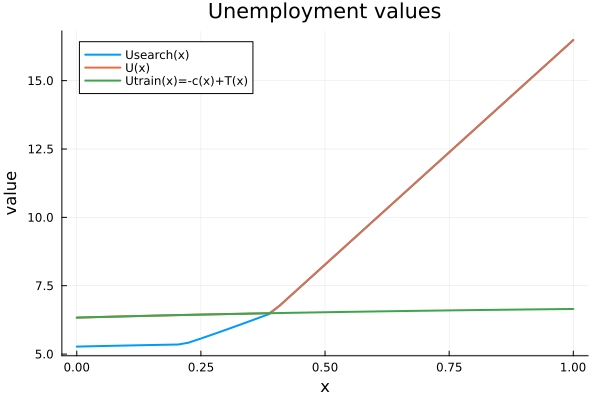

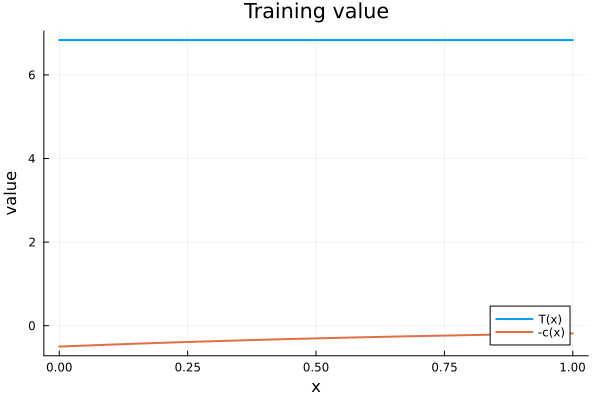

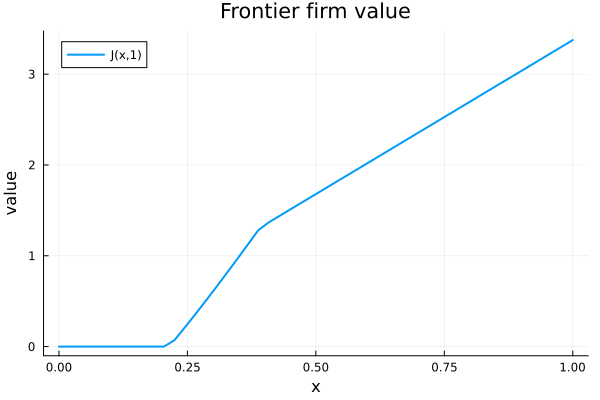

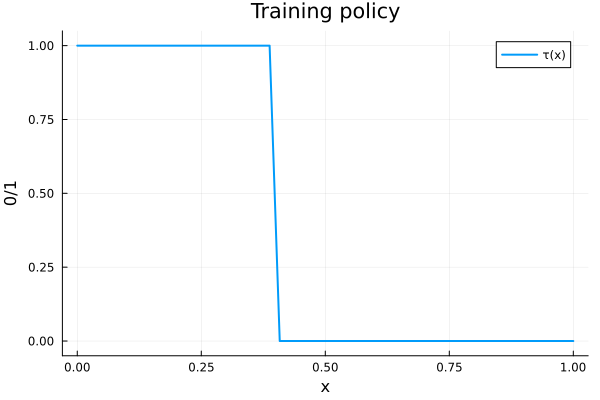

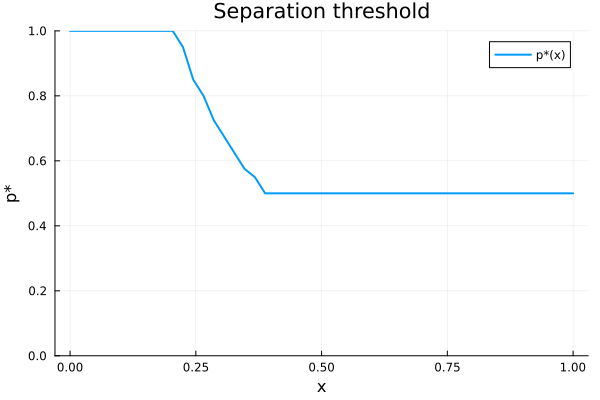

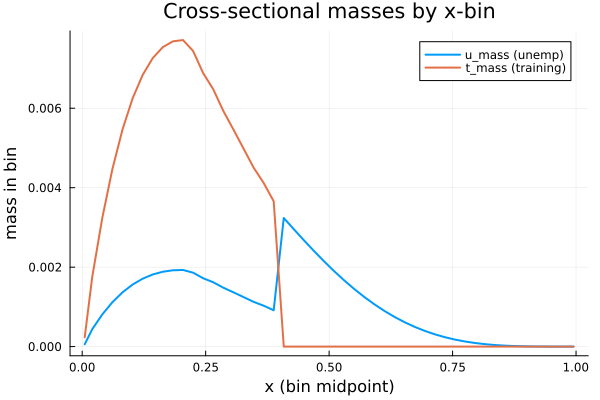

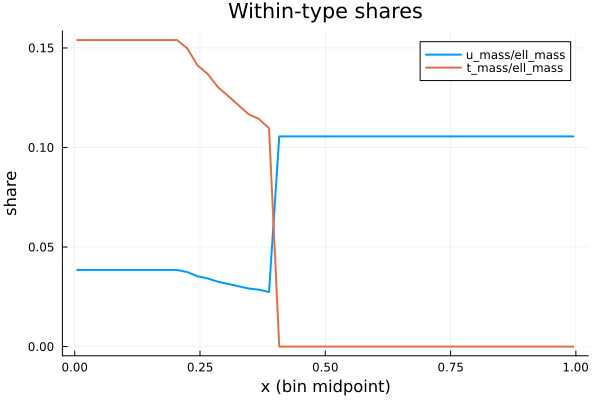

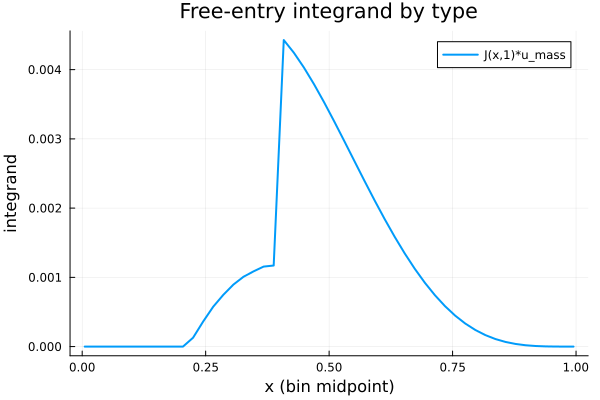

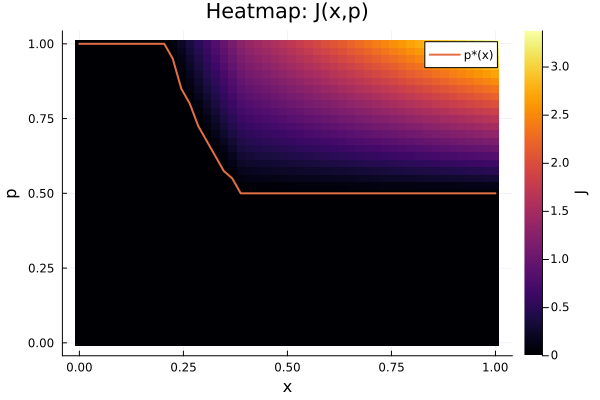

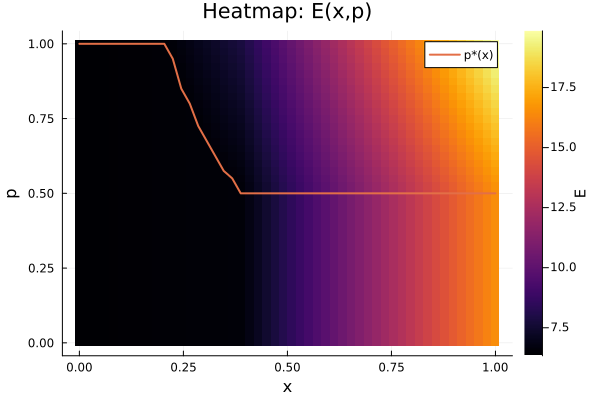

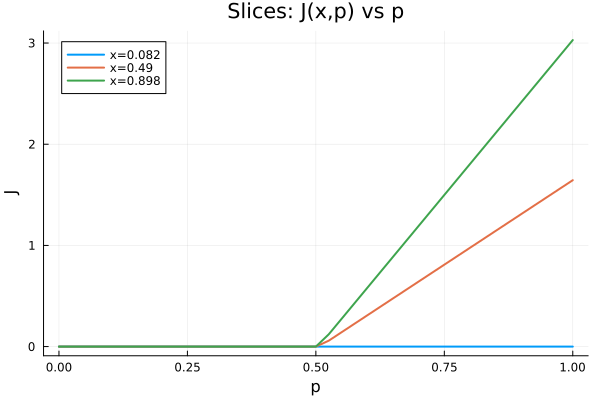

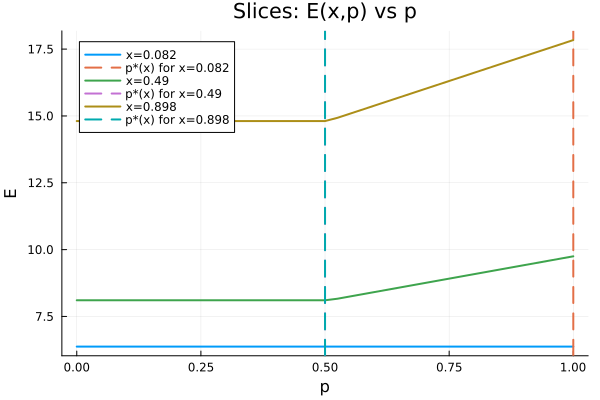

(J_heat = Plot{Plots.GRBackend() n=2}, E_heat = Plot{Plots.GRBackend() n=2}, J_slices = Plot{Plots.GRBackend() n=3}, E_slices = Plot{Plots.GRBackend() n=6}, x_indices = [5, 25, 45])

In [24]:
# =========================
# Cell 10 — Plotting utilities + all plots
# =========================
using Plots

# --- helpers ---
@inline midpoints_from_edges(edges::Vector{Float64}) = 0.5 .* (edges[1:end-1] .+ edges[2:end])

function _vline!(x; lab="", ls=:dash, lw=2)
    vline!([x]; label=lab, linestyle=ls, linewidth=lw)
end

# --- 1–4, 8–12: x-based plots + diagnostics ---
function plot_unskilled_x_objects(state, cache, par, grid; show=true)
    x = grid.x
    xm = midpoints_from_edges(grid.x_edges)  # for mass-by-bin plots (length Nx)

    # Derived objects
    Utrain = @. -par.c(x) + state.Tval
    τfloat = Float64.(state.τ)

    # ----- (1) Usearch vs U vs Utrain
    p1 = plot(x, state.Usearch; label="Usearch(x)", xlabel="x", ylabel="value",
              title="Unemployment values", linewidth=2)
    plot!(p1, x, state.U; label="U(x)", linewidth=2)
    plot!(p1, x, Utrain; label="Utrain(x)=-c(x)+T(x)", linewidth=2)

    # ----- (2) T(x) and -c(x)
    p2 = plot(x, state.Tval; label="T(x)", xlabel="x", ylabel="value",
              title="Training value", linewidth=2)
    plot!(p2, x, @. -par.c(x); label="-c(x)", linewidth=2)

    # ----- (3) J_frontier(x)
    p3 = plot(x, state.J_frontier; label="J(x,1)", xlabel="x", ylabel="value",
              title="Frontier firm value", linewidth=2)

    # ----- (4) τ(x)
    p4 = plot(x, τfloat; label="τ(x)", xlabel="x", ylabel="0/1",
              title="Training policy", linewidth=2, ylim=(-0.05, 1.05))

    # ----- (8) pstar(x)
    p5 = plot(x, state.pstar; label="p*(x)", xlabel="x", ylabel="p*",
              title="Separation threshold", linewidth=2, ylim=(0.0, 1.0))

    # ----- (9) u_mass and t_mass (bin masses)
    p6 = plot(xm, state.u_mass; label="u_mass (unemp)", xlabel="x (bin midpoint)",
              ylabel="mass in bin", title="Cross-sectional masses by x-bin", linewidth=2)
    plot!(p6, xm, state.t_mass; label="t_mass (training)", linewidth=2)

    # ----- (10) shares: u/ell and t/ell
    u_share = state.u_mass ./ cache.ell_mass
    t_share = state.t_mass ./ cache.ell_mass
    p7 = plot(xm, u_share; label="u_mass/ell_mass", xlabel="x (bin midpoint)",
              ylabel="share", title="Within-type shares", linewidth=2)
    plot!(p7, xm, t_share; label="t_mass/ell_mass", linewidth=2)

    # ----- (11) free-entry integrand J_frontier(x) * u_mass(x)
    integrand = state.J_frontier .* state.u_mass
    p8 = plot(xm, integrand; label="J(x,1)*u_mass", xlabel="x (bin midpoint)",
              ylabel="integrand", title="Free-entry integrand by type", linewidth=2)

    # ----- (12) (optional placeholder) outer-history plots
    # You can pass in stored vectors later; for now we just return plots.

    if show
        display(p1); display(p2); display(p3); display(p4)
        display(p5); display(p6); display(p7); display(p8)
    end
    return (p1=p1, p2=p2, p3=p3, p4=p4, p5=p5, p6=p6, p7=p7, p8=p8)
end

# --- 5–7: (x,p) heatmaps + slices ---
function plot_unskilled_xp_objects(state, par, grid; show=true,
                                  x_indices::Vector{Int}=Int[],
                                  use_quantiles::Bool=true)

    x = grid.x
    p = grid.p
    Nx = length(x)
    Np = length(p)

    # choose x indices
    if isempty(x_indices)
        if use_quantiles
            x_indices = unique(clamp.(round.(Int, [0.10, 0.50, 0.90] .* Nx), 1, Nx))
        else
            x_indices = [1, Int(round(Nx/2)), Nx]
        end
    end

    # ----- (5) heatmap J(x,p)
    # Plots.jl heatmap expects z matrix with y as rows, x as cols; we’ll transpose.
    h1 = heatmap(x, p, state.JU'; xlabel="x", ylabel="p",
                 title="Heatmap: J(x,p)", colorbar_title="J")

    # overlay pstar frontier as a line
    plot!(h1, x, state.pstar; label="p*(x)", linewidth=2)

    # ----- (6) heatmap E(x,p)
    h2 = heatmap(x, p, state.EU'; xlabel="x", ylabel="p",
                 title="Heatmap: E(x,p)", colorbar_title="E")
    plot!(h2, x, state.pstar; label="p*(x)", linewidth=2)

    # ----- (7) slices in p for selected x
    sJ = plot(title="Slices: J(x,p) vs p", xlabel="p", ylabel="J", legend=:topleft)
    sE = plot(title="Slices: E(x,p) vs p", xlabel="p", ylabel="E", legend=:topleft)

    for (k, i) in enumerate(x_indices)
        lab = "x=$(round(x[i]; digits=3))"
        plot!(sJ, p, view(state.JU, i, :); label=lab, linewidth=2)
        plot!(sE, p, view(state.EU, i, :); label=lab, linewidth=2)
        _vline!(state.pstar[i]; lab="p*(x) for $lab")
    end

    if show
        display(h1); display(h2); display(sJ); display(sE)
    end
    return (J_heat=h1, E_heat=h2, J_slices=sJ, E_slices=sE, x_indices=x_indices)
end

# --- 12: optional outer-loop history tracking (plug into solve_model! later) ---
mutable struct OuterHistory
    θ::Vector{Float64}
    τshare::Vector{Float64}
    pmin::Vector{Float64}
    pmax::Vector{Float64}
    Jbar::Vector{Float64}
end
OuterHistory() = OuterHistory(Float64[], Float64[], Float64[], Float64[], Float64[])

function push_history!(hist::OuterHistory, state, cache)
    push!(hist.θ, state.θU)
    push!(hist.τshare, mean(state.τ))
    push!(hist.pmin, minimum(state.pstar))
    push!(hist.pmax, maximum(state.pstar))
    # Jbar ≈ ∑ J_frontier(x)*u_mass(x)
    push!(hist.Jbar, sum(state.J_frontier .* state.u_mass))
    return nothing
end

function plot_outer_history(hist::OuterHistory; show=true)
    it = 1:length(hist.θ)

    p1 = plot(it, hist.θ; xlabel="outer iteration", ylabel="θU", title="θU path", label="θU", linewidth=2)
    p2 = plot(it, hist.τshare; xlabel="outer iteration", ylabel="mean(τ)", title="Training share path", label="mean τ", linewidth=2)

    p3 = plot(it, hist.pmin; xlabel="outer iteration", ylabel="p*", title="p* min/max path", label="min p*", linewidth=2)
    plot!(p3, it, hist.pmax; label="max p*", linewidth=2)

    p4 = plot(it, hist.Jbar; xlabel="outer iteration", ylabel="Jbar", title="Composition-weighted frontier surplus", label="Jbar", linewidth=2)

    if show
        display(p1); display(p2); display(p3); display(p4)
    end
    return (θ=p1, τ=p2, pstar=p3, Jbar=p4)
end

# =========================
# Cell 11 — Run all plots
# =========================

# x-based plots (1–4, 8–11)
plot_unskilled_x_objects(state, cache, par, grid)

# (x,p) plots (5–7)
plot_unskilled_xp_objects(state, par, grid)